In [14]:
# For autoreloading the classes so you do not need to restart the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Importing the libraries
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import sys
sys.path.append(os.path.abspath("../python"))

from EventReader import EventReader
from EventReader import show_data
from Model import SuperResolutionModel
from Model import create_datasets
from ModelUtils import *

In [16]:
r = 2.5 # radius of the detector in cm

In [17]:
# show data in directory
data_dir = '/mnt/c/Users/marjo/data/'
show_data(data_dir)

,subdir,detector,nevents,nphoton_per_event,set_no_scatter,set_experimental_scatter_model,radius
0,mc0000,XAMS,1000,100000,False,True,3.2
1,mc0001,XAMS,10000,10000,False,True,3.2
2,mc0002,XAMS,10000,10000,True,True,3.2
3,mc0003,XAMS,10000,10000,False,False,3.2
4,mc0004,XAMS,10000,10000,False,True,3.2
5,mc0005,XAMS,10000,10000,True,True,3.2


In [18]:
# read data
files = glob.glob(data_dir + 'mc0001/*000*.hd5f')
events = EventReader(files)

number of files:  100


In [19]:
# get the necessary information from the events
n = 0
nmax =100000 # if you do not want to loop over all events

true_pos = []
fine_top = []
top = []

for ev in events:
    if n%10000 == 0:
        print('processed ', n, 'events')
    n+=1
    
    # retrieve the true hit position
    truth = ev['true_position']
    true_pos.append(truth)
                    
    # get the data from the top PMT    
    pmt = ev['pmt_top'][()]
    top.append(pmt.T)
    fine_pmt = ev['fine_top'][()]
    fine_top.append(fine_pmt.T)

    if n>=nmax:
        print('processed ', nmax, 'events')
        break

events.reset()

processed  0 events
processed  10000 events
processed  20000 events
processed  30000 events
processed  40000 events
processed  50000 events
processed  60000 events
processed  70000 events
processed  80000 events
processed  90000 events
processed  100000 events


In [20]:
print(f"We have {len(top)} events")
print(f"low res PMT has shape {top[0].shape}")
print(f"high res truth has shape {fine_top[0].shape}")
print(f"true positions have shape {true_pos[0].shape}")

We have 100000 events
low res PMT has shape (2, 2)
high res truth has shape (20, 20)
true positions have shape (3,)


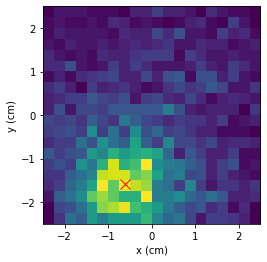

In [21]:
# check if data is ok
num = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.imshow(
    top[num], interpolation="nearest", origin="lower", extent=[-r, r, -r, r]
)
ax.imshow(
    fine_top[num],
    interpolation="nearest",
    origin="lower",
    extent=[-2.5, 2.5, -2.5, 2.5],
)
ax.plot(
    true_pos[num][0],
    true_pos[num][1],
    marker="x",
    markersize=10,
    color="red",
    label="true position",
)
plt.xlabel("x (cm)")
plt.ylabel("y (cm)")
plt.show()

In [22]:
# create train and test sets
y = fine_top # downsample if wanted
X = top
pos = [pos[:2] for pos in true_pos] # depth is not used

X_train, y_train, pos_train, X_test, y_test, pos_test = create_datasets(
    X, y, pos, train_fraction=0.8
)
y_train_downsampled = downsample_heatmaps_to_dimensions(y_train, 10, 10)
y_test_downsampled = downsample_heatmaps_to_dimensions(y_test, 10, 10)

In [23]:
model = SuperResolutionModel(low_to_high_res_net_params=
    {"hidden_layer_sizes":(100,100),
    "activation":"relu", 
    "solver":"adam", 
    "alpha":0.0001, 
    "batch_size":"auto", 
    "learning_rate":"constant", 
    "learning_rate_init":0.001, 
    "power_t":0.5, 
    "max_iter":200, 
    "shuffle":True, 
    "random_state":None, 
    "tol":1e-4, 
    "verbose":False, 
    "warm_start":False, 
    "momentum":0.9, 
    "nesterovs_momentum":True, 
    "early_stopping":True, 
    "validation_fraction":0.1, 
    "beta_1":0.9, 
    "beta_2":0.999, 
    "epsilon":1e-8, 
    "n_iter_no_change":10, 
    "max_fun":15000}, 
    high_res_to_true_net_params=
    {"hidden_layer_sizes":(100,),
    "activation":"relu", 
    "solver":"adam", 
    "alpha":0.0001, 
    "batch_size":"auto", 
    "learning_rate":"constant", 
    "learning_rate_init":0.001, 
    "power_t":0.5, 
    "max_iter":200, 
    "shuffle":True, 
    "random_state":None, 
    "tol":1e-4, 
    "verbose":False, 
    "warm_start":False, 
    "momentum":0.9, 
    "nesterovs_momentum":True, 
    "early_stopping":True, 
    "validation_fraction":0.1, 
    "beta_1":0.9, 
    "beta_2":0.999, 
    "epsilon":1e-8, 
    "n_iter_no_change":10, 
    "max_fun":15000})


In [29]:
model.train(X_train, y_train_downsampled, pos_train)

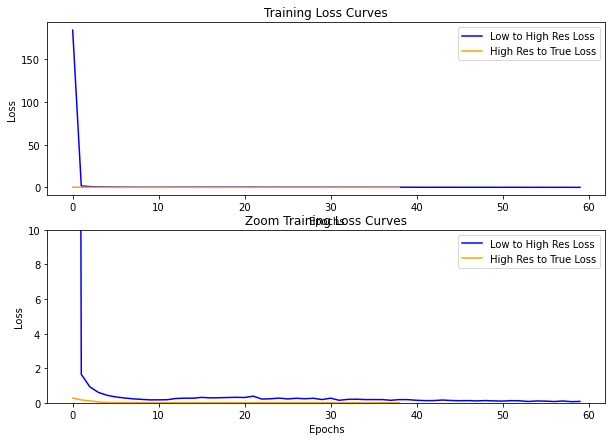

In [30]:
model.plot_loss_curve()

In [31]:
# save
with open('model3.pkl','wb') as f:
    pickle.dump(model,f)